# Geoplanar Example with Building Footprints

This notebook provides an example of preprocessing building footprints for the centre of Berlin.

*Note that you will need to have pyarrow installed if you want to read the parquet files. 

```
conda install -c conda-forge pyarrow

or 

pip install pyarrow
```

Notebook contents:

0. Import data and make valid, explode multipolygons, keep only polygons

1. Overlapping buildings

    1a. Merge overlapping buildings

    1b. Trim remaining overlapping buildings
    
2. Merge collapsed buildings
3. Snap buildings

## 0. Import data and make valid, explode multipolygons, keep only polygons

In [1]:
import numpy as np
import geopandas as gpd
import geoplanar

In [2]:
buildings = gpd.read_parquet("../../../geoplanar/datasets/buildings_berlin.parquet")
buildings = buildings.to_crs(crs=31468)

<Axes: >

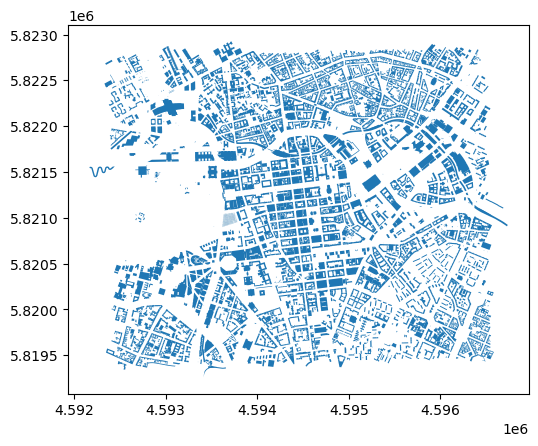

In [3]:
buildings.plot()

In [4]:
buildings.explore()

In [5]:
buildings.type.value_counts()

Polygon         8714
MultiPolygon       2
Name: count, dtype: int64

In [6]:
# make valid
buildings["geometry"] = buildings.make_valid()

In [7]:
buildings.type.value_counts()

Polygon               8710
MultiPolygon             4
GeometryCollection       2
Name: count, dtype: int64

In [8]:
# explode GeometryCollection and MultiPolygon
buildings = buildings.explode(ignore_index=True)

In [9]:
buildings.type.value_counts()

Polygon       8721
LineString       2
Name: count, dtype: int64

In [10]:
# remove non-Polygon geometries
buildings = buildings[buildings.type == "Polygon"]

In [11]:
buildings.type.value_counts()

Polygon    8721
Name: count, dtype: int64

## 1. Overlapping buildings

### 1a. Merge overlapping buildings

In [12]:
buildings=buildings.reset_index(drop=True)
buildings.shape

(8721, 1)

In [13]:
# set precision so that polygons don't have rounding errors and are effectively snapped to the same precision grid
buildings["geometry"] = buildings.set_precision(0.00001)
buildings.shape

(8721, 1)

In [14]:
buildings.type.value_counts()

Polygon    8721
Name: count, dtype: int64

In [15]:
## merge buildings that overlap either 1) at least .10 percent or 2) 500sqm
buildings = geoplanar.merge_overlaps(buildings, merge_limit=500, overlap_limit=0.1)
buildings.shape

(8620, 1)

In [16]:
#the output may result in MultiPolygons. This is typically a result of a complex relationship between geometries and is expected. 
# These multipolygons are usually comprised of just one polygon so can be exploded
buildings.type.value_counts()

Polygon    8620
Name: count, dtype: int64

In [17]:
buildings.type.value_counts()

Polygon    8620
Name: count, dtype: int64

### 1b. Trim overlapping buildings

In [18]:
from collections import defaultdict

import geopandas
import libpysal
import numpy as np
from packaging.version import Version
from esda.shape import isoperimetric_quotient

__all__ = [
    "overlaps",
    "trim_overlaps",
    "is_overlapping",
    "merge_overlaps",
    "merge_touching",
]

GPD_GE_014 = Version(geopandas.__version__) >= Version("0.14.0")



def trim_overlaps(gdf, strategy='largest', inplace=False):


    """Trim overlapping polygons

    Note
    ----
    Under certain circumstances, the output may result in MultiPolygons. This is
    typically a result of a complex relationship between geometries and is expected.
    Just note, that it may require further treatment if simple Polygons are needed.

    Parameters
    ----------

    gdf:  geodataframe with polygon geometries

    strategy : {'smallest', 'largest', 'compact', None}, default 'largest'
        Strategy to determine which polygon to trim.
          - 'smallest': Trim the smallest polygon.
          - 'largest' : Trim the largest polygon.
          - 'compact' : Trim the polygon yielding the most compact modified polygon.
                            (isoperimetric quotient).
          - None      : Trim either polygon non-deterministically but performantly.
    
    Returns
    -------

    gdf: geodataframe with corrected geometries

    """
    if GPD_GE_014:
        intersections = gdf.sindex.query(gdf.geometry, predicate="overlaps").T
    else:
        intersections = gdf.sindex.query_bulk(gdf.geometry, predicate="overlaps").T

    if not inplace:
        gdf = gdf.copy()

    geom_col_idx = gdf.columns.get_loc(gdf.geometry.name)

    if strategy is None:  # don't care which polygon to trim
        for i, j in intersections:
            if i != j:
                left = gdf.geometry.iloc[i]
                right = gdf.geometry.iloc[j]
                gdf.iloc[j, geom_col_idx] = right.difference(left)
    elif strategy=='largest':
        for i, j in intersections:
            if i != j:
                left = gdf.geometry.iloc[i]
                right = gdf.geometry.iloc[j]
                if left.area > right.area:  # trim left
                    gdf.iloc[i, geom_col_idx] = left.difference(right)
                else:
                    gdf.iloc[j, geom_col_idx] = right.difference(left)
    elif strategy=='smallest':
        for i, j in intersections:
            if i != j:
                left = gdf.geometry.iloc[i]
                right = gdf.geometry.iloc[j]
                if left.area < right.area:  # trim left
                    gdf.iloc[i, geom_col_idx] = left.difference(right)
                else:
                    gdf.iloc[j, geom_col_idx] = right.difference(left)
    elif strategy=='compact':
         for i, j in intersections:
             if i != j:
                 left = gdf.geometry.iloc[i]
                 right = gdf.geometry.iloc[j]
                 left_c = left.difference(right)
                 right_c = right.difference(left)
                 iq_left = isoperimetric_quotient(left_c)
                 iq_right = isoperimetric_quotient(right_c)
                 if iq_left > iq_right:  # trimming left is more compact than right
                     gdf.iloc[i, geom_col_idx] = left_c
                 else:
                     gdf.iloc[j, geom_col_idx] = right_c
    return gdf

In [19]:
## trim remaining overlaps
buildings = trim_overlaps(buildings, strategy="largest")
buildings.shape

(8620, 1)

In [20]:
buildings.type.value_counts()

Polygon    8620
Name: count, dtype: int64

In [21]:
# check for remaining overlaps
overlaps = geoplanar.overlaps(buildings)

In [22]:
overlaps

array([[  58,   67,  575, 4208, 4729, 4748, 4908, 5605, 5633, 5794, 6428,
        6432, 6494, 7291, 8051, 8520, 8520, 8564],
       [7291, 5605, 6494, 5794, 4748, 4729, 5633,   67, 4908, 4208, 6432,
        6428,  575,   58, 8520, 8564, 8051, 8520]])

In [23]:
# remaining overlaps result from floating point errors
buildings.iloc[overlaps[0]].explore()

## 2. Merge Collapsed Buildings

Checks for tiny polygons which are too small to represent individual buildings. Buffer size can be changed from 0.4 to the appropriate distance.

In [24]:
buildings = buildings.reset_index(drop=True)

In [25]:
buildings

geometry
0     POLYGON ((4593474.968 5820516.514, 4593483.628...
1     POLYGON ((4593637.723 5821622.766, 4593637.682...
2     POLYGON ((4593340.989 5821617.532, 4593335.228...
3     POLYGON ((4593637.228 5821648.658, 4593637.593...
4     POLYGON ((4593048.473 5822123.631, 4593039.152...
...                                                 ...
8615  POLYGON ((4595744.168 5819514.447, 4595745.47 ...
8616  POLYGON ((4593324.001 5822407.84, 4593311.809 ...
8617  POLYGON ((4595410.803 5821222.138, 4595446.032...
8618  POLYGON ((4593894.427 5821361.441, 4593937.58 ...
8619  POLYGON ((4596233.141 5822815.254, 4596228.114...

[8620 rows x 1 columns]

In [26]:
shrink=buildings.buffer(-0.4, resolution=2)
emptycheck = shrink.is_empty

In [27]:
buildings.loc[shrink.is_empty]

geometry
487   POLYGON ((4592587.167 5820479.718, 4592587.491...
2259  POLYGON ((4593697.054 5820923.71, 4593697.046 ...
3010  POLYGON ((4593646.046 5820966.471, 4593648.312...
3079  POLYGON ((4593642.744 5820966.408, 4593644.945...
3165  POLYGON ((4593649.42 5820966.111, 4593649.412 ...
3592  POLYGON ((4593654.972 5820967.066, 4593654.988...
7786  POLYGON ((4595508.06 5820890.281, 4595526.757 ...

In [28]:
buildings.loc[shrink.is_empty].explore()

In [29]:
# merge touching collapsing buildings
buildings = geoplanar.merge_touching(buildings, shrink.is_empty, largest=True)
buildings.shape

(8613, 1)

In [30]:
# check if merge_touching has worked
shrink=buildings.buffer(-0.4, resolution=2)
emptycheck = shrink.is_empty
buildings[emptycheck]

Empty GeoDataFrame
Columns: [geometry]
Index: []

## 3. Snap Buildings

In [38]:
# snap nearby buildings
buildings["geometry"] = geoplanar.snap(buildings, threshold=0.5)
buildings.shape

(8613, 1)

In [39]:
buildings.type.value_counts()

Polygon    8613
Name: count, dtype: int64

In [40]:
buildings

geometry
0     POLYGON ((4593474.968 5820516.514, 4593483.628...
1     POLYGON ((4593637.723 5821622.766, 4593637.682...
2     POLYGON ((4593340.989 5821617.532, 4593335.228...
3     POLYGON ((4593637.228 5821648.658, 4593637.593...
4     POLYGON ((4593048.473 5822123.631, 4593039.152...
...                                                 ...
8615  POLYGON ((4595744.168 5819514.447, 4595745.47 ...
8616  POLYGON ((4593324.001 5822407.84, 4593311.809 ...
8617  POLYGON ((4595410.803 5821222.138, 4595446.032...
8618  POLYGON ((4593894.427 5821361.441, 4593937.58 ...
8619  POLYGON ((4596233.141 5822815.254, 4596228.114...

[8613 rows x 1 columns]

In [41]:
buildings.is_valid.value_counts()


True    8613
Name: count, dtype: int64

In [44]:
# The following should not be part of the example but I think snapping is not working as expected
# because before and after snapping, the snapping algorithm still identifies the same pairs to snap

In [36]:
# before snapping

In [31]:
nearby_a, nearby_b = buildings.sindex.query(
        buildings.geometry, predicate="dwithin", distance=0.5
    )

In [32]:
len(nearby_a)

20853

In [33]:
import pandas as pd

In [34]:
nearby_a, nearby_b = buildings.sindex.query(
    buildings.geometry, predicate="dwithin", distance=0.5
)
overlap_a, overlap_b = buildings.boundary.sindex.query(
    buildings.boundary, predicate="overlaps"
)

self_mask = nearby_a != nearby_b
nearby_a = nearby_a[self_mask]
nearby_b = nearby_b[self_mask]

self_mask = overlap_a != overlap_b
overlap_a = overlap_a[self_mask]
overlap_b = overlap_b[self_mask]

nearby = pd.MultiIndex.from_arrays([nearby_a, nearby_b], names=("source", "target"))
overlap = pd.MultiIndex.from_arrays(
    [overlap_a, overlap_b], names=("source", "target")
)
nearby_not_overlap = nearby.difference(overlap)

In [35]:
nearby_not_overlap

MultiIndex([(  39, 1446),
            (  39, 7171),
            (  40, 7273),
            (  54,   57),
            (  56,   57),
            (  57,   54),
            (  57,   56),
            (  71, 7937),
            (  93,  143),
            (  95,  160),
            ...
            (8454, 8452),
            (8454, 8453),
            (8477, 5017),
            (8499, 5109),
            (8501, 1292),
            (8504, 6806),
            (8549, 5609),
            (8581, 7992),
            (8599, 5810),
            (8612, 6432)],
           names=['source', 'target'], length=860)

In [37]:
# after snapping

In [42]:
geometry = buildings

In [43]:
threshold=0.5

In [44]:
if not nearby_not_overlap.empty:
    duplicated = pd.DataFrame(
        np.sort(np.array(nearby_not_overlap.to_list()), axis=1)
    ).duplicated()
    pairs_to_snap = nearby_not_overlap[~duplicated]

In [45]:
pairs_to_snap

MultiIndex([(  39, 1446),
            (  39, 7171),
            (  40, 7273),
            (  54,   57),
            (  56,   57),
            (  71, 7937),
            (  93,  143),
            (  95,  160),
            (  96, 7312),
            ( 131, 7858),
            ...
            (7799, 7800),
            (7977, 7979),
            (7992, 8581),
            (8128, 8256),
            (8166, 8431),
            (8202, 8303),
            (8225, 8231),
            (8452, 8453),
            (8452, 8454),
            (8453, 8454)],
           names=['source', 'target'], length=430)